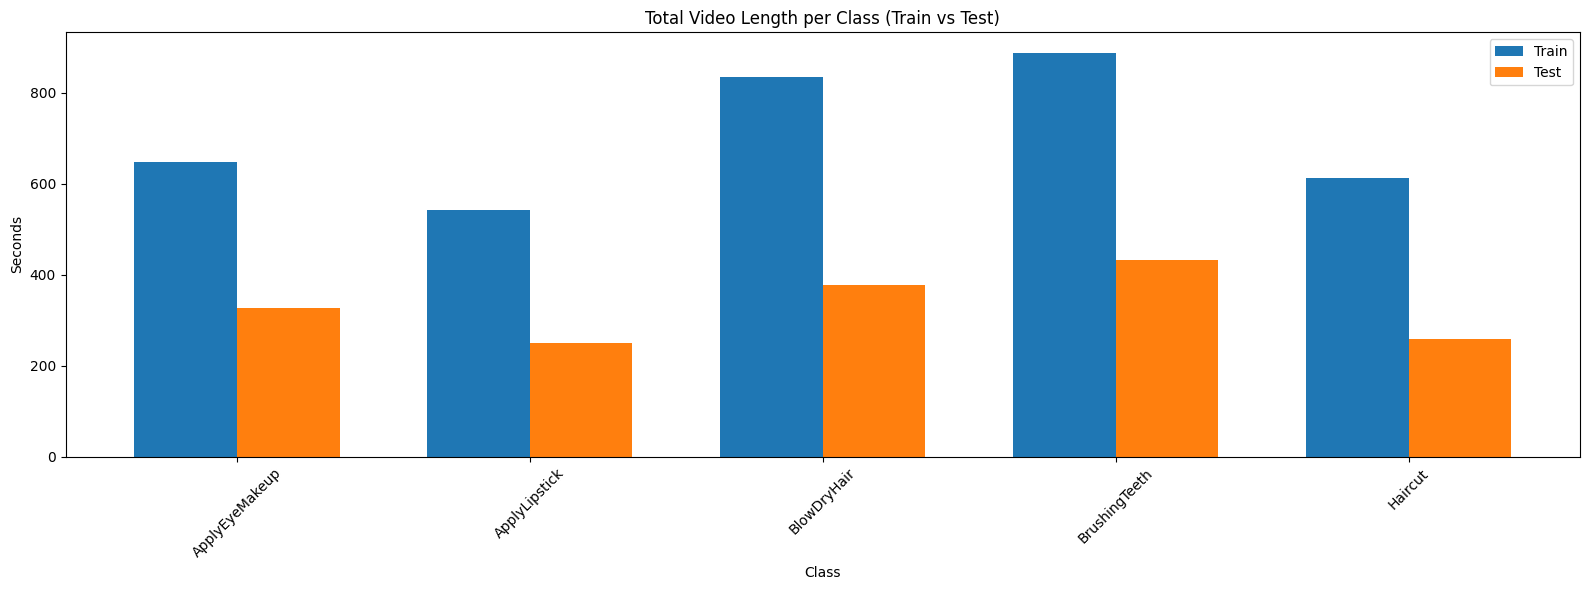

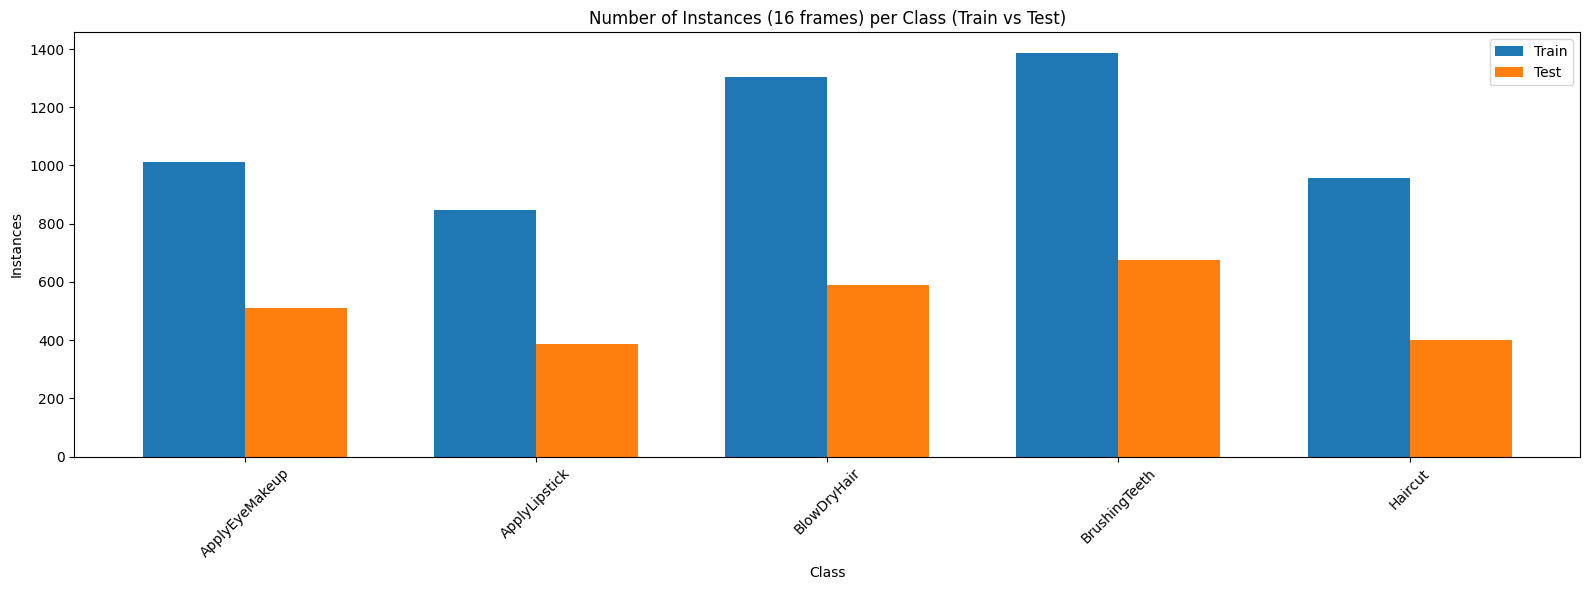

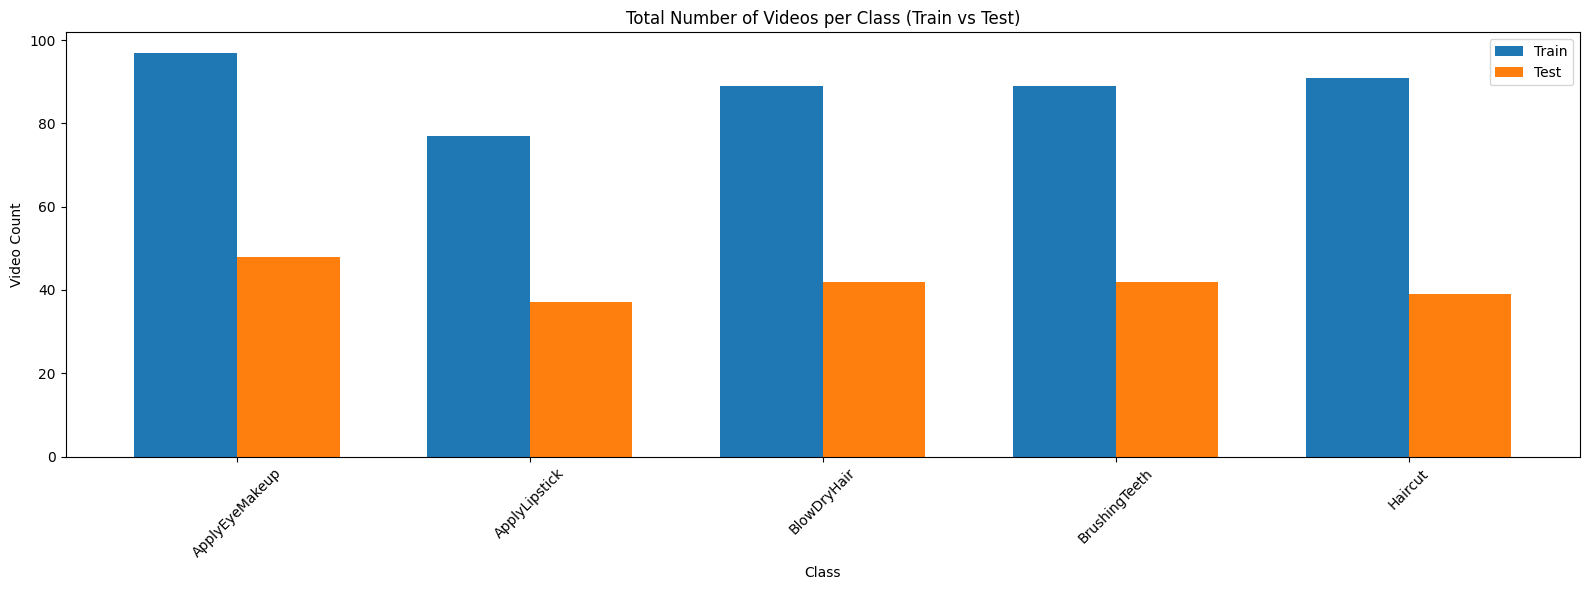


=== Global Video Properties ===
Frame rate (FPS): 25.0
Frame width: 320 pixels
Frame height: 240 pixels



In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = "../data/Split/UCF101-nobackground/"
TRAIN_LIST_PATH = "../data/Split/split_info-nobackground/trainlist01.txt" 

with open(TRAIN_LIST_PATH, "r") as f:
    train_videos = set(line.strip().split()[0] for line in f)

def init_stats():
    return {
        "class_name": [],
        "total_length_sec": [],
        "instances": [],
        "video_count": []
    }

train_stats = init_stats()
test_stats = init_stats()

global_fps = None
global_width = None
global_height = None

def update_stats(stats, class_name, class_length, class_frames, video_count):
    stats["class_name"].append(class_name)
    stats["total_length_sec"].append(class_length)
    stats["instances"].append(class_frames // 16)
    stats["video_count"].append(video_count)

for class_name in os.listdir(DATA_PATH):
    class_dir = os.path.join(DATA_PATH, class_name)

    if not os.path.isdir(class_dir):
        continue 

    class_stats = {
        "train": {"class_length": 0, "class_frames": 0, "video_count": 0},
        "test": {"class_length": 0, "class_frames": 0, "video_count": 0}
    }

    for video in os.listdir(class_dir):
        if not video.endswith(".avi"):
            continue

        relative_video_path = f"{class_name}/{video}"
        split = "train" if relative_video_path in train_videos else "test"

        video_path = os.path.join(class_dir, video)
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            cap.release()
            continue

        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        cap.release()

        if global_fps is None:
            global_fps = fps
            global_width = width
            global_height = height

        if fps > 0:
            class_stats[split]["class_length"] += total_frames / fps
            class_stats[split]["class_frames"] += total_frames
            class_stats[split]["video_count"] += 1

    if class_stats["train"]["video_count"] > 0:
        update_stats(train_stats, class_name, **class_stats["train"])

    if class_stats["test"]["video_count"] > 0:
        update_stats(test_stats, class_name, **class_stats["test"])

def plot_stats(train_stats, test_stats, metric_key, title, ylabel):
    x = np.arange(len(train_stats["class_name"])) 
    width = 0.35

    fig, ax = plt.subplots(figsize=(16, 6))
    ax.bar(x - width/2, train_stats[metric_key], width, label='Train')
    ax.bar(x + width/2, test_stats[metric_key], width, label='Test')

    ax.set_xlabel('Class')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(train_stats["class_name"], rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()

# === Plot selected metrics
plot_stats(train_stats, test_stats, "total_length_sec", "Total Video Length per Class (Train vs Test)", "Seconds")
plot_stats(train_stats, test_stats, "instances", "Number of Instances (16 frames) per Class (Train vs Test)", "Instances")
plot_stats(train_stats, test_stats, "video_count", "Total Number of Videos per Class (Train vs Test)", "Video Count")

# === Print global video properties ===
print("\n=== Global Video Properties ===")
print(f"Frame rate (FPS): {global_fps}")
print(f"Frame width: {global_width} pixels")
print(f"Frame height: {global_height} pixels")
print("==============================\n")